<a href="https://colab.research.google.com/github/ddoneu/ECON3916-Statistical-Machine-Learning/blob/main/Lab2/Lab2%20FRED%20API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install fredapi

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key= '0d5346e9e92063e7c20dbf4b175c4bd2')

In [6]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [7]:
#update code v2

In [9]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


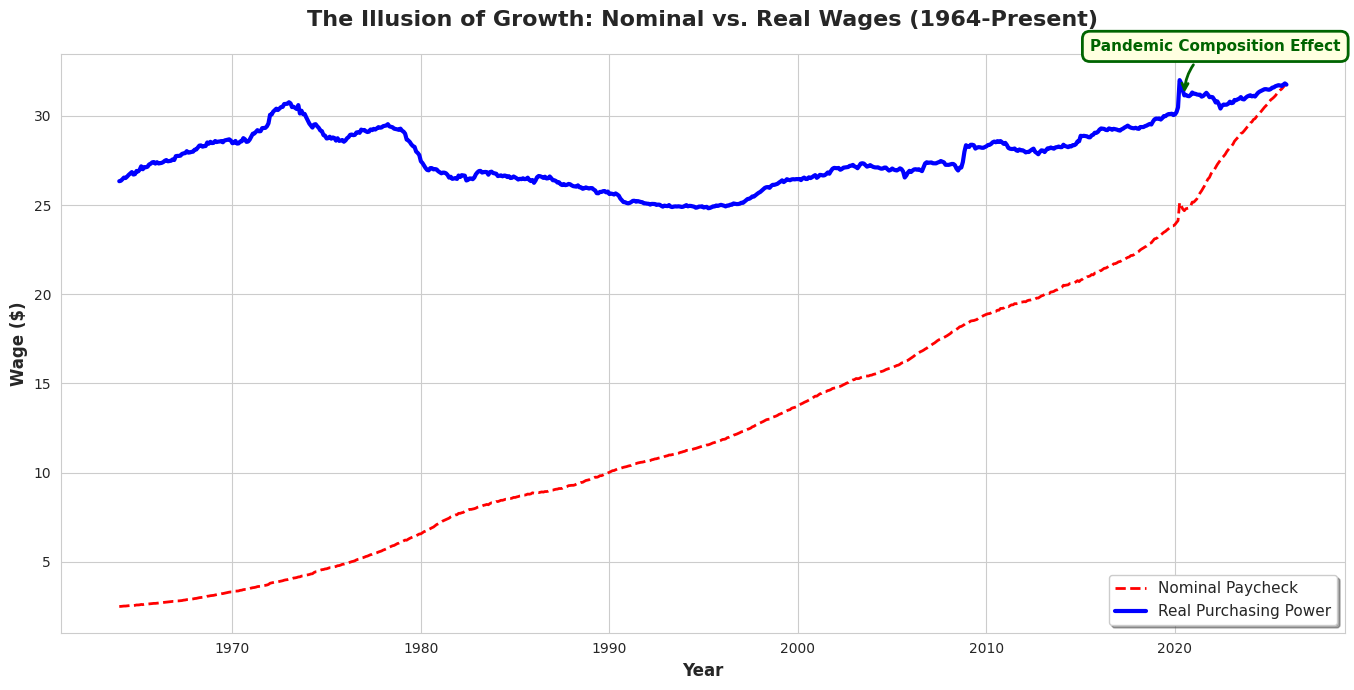

In [11]:
# Set the style
sns.set_style("whitegrid")

# Create figure with specified size
fig, ax = plt.subplots(figsize=(14, 7))

# Plot Nominal Wage (dashed red line)
ax.plot(df.index, df['Nominal_Wage'],
        color='red',
        linestyle='--',
        linewidth=2,
        label='Nominal Paycheck')

# Plot Real Wage (thick blue line)
ax.plot(df.index, df['Real_Wage'],
        color='blue',
        linewidth=3,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title('The Illusion of Growth: Nominal vs. Real Wages (1964-Present)',
             fontsize=16,
             fontweight='bold',
             pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Wage ($)', fontsize=12, fontweight='bold')

# Add legend
ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)

# Add annotation arrow for 2020 pandemic spike
try:
    # Find 2020 data
    mask_2020 = (df.index.year == 2020)
    if mask_2020.any():
        # Use middle of 2020 data if multiple points exist
        idx_2020 = df.index[mask_2020][len(df.index[mask_2020])//2]
        real_2020 = df.loc[idx_2020, 'Real_Wage']

        ax.annotate('Pandemic Composition Effect',
                    xy=(idx_2020, real_2020),
                    xytext=(idx_2020 - pd.DateOffset(years=5), real_2020 * 1.08),
                    fontsize=11,
                    fontweight='bold',
                    color='darkgreen',
                    bbox=dict(boxstyle='round,pad=0.5',
                             facecolor='lightyellow',
                             edgecolor='darkgreen',
                             linewidth=2),
                    arrowprops=dict(arrowstyle='->',
                                   connectionstyle='arc3,rad=0.3',
                                   color='darkgreen',
                                   lw=2))
except Exception as e:
    print(f"Note: Could not add 2020 annotation: {e}")

# Improve layout
plt.tight_layout()
plt.show()

Fetching ECI data from FRED...
Note: Could not add 2020 annotations: Non-integer years and months are ambiguous and not currently supported.


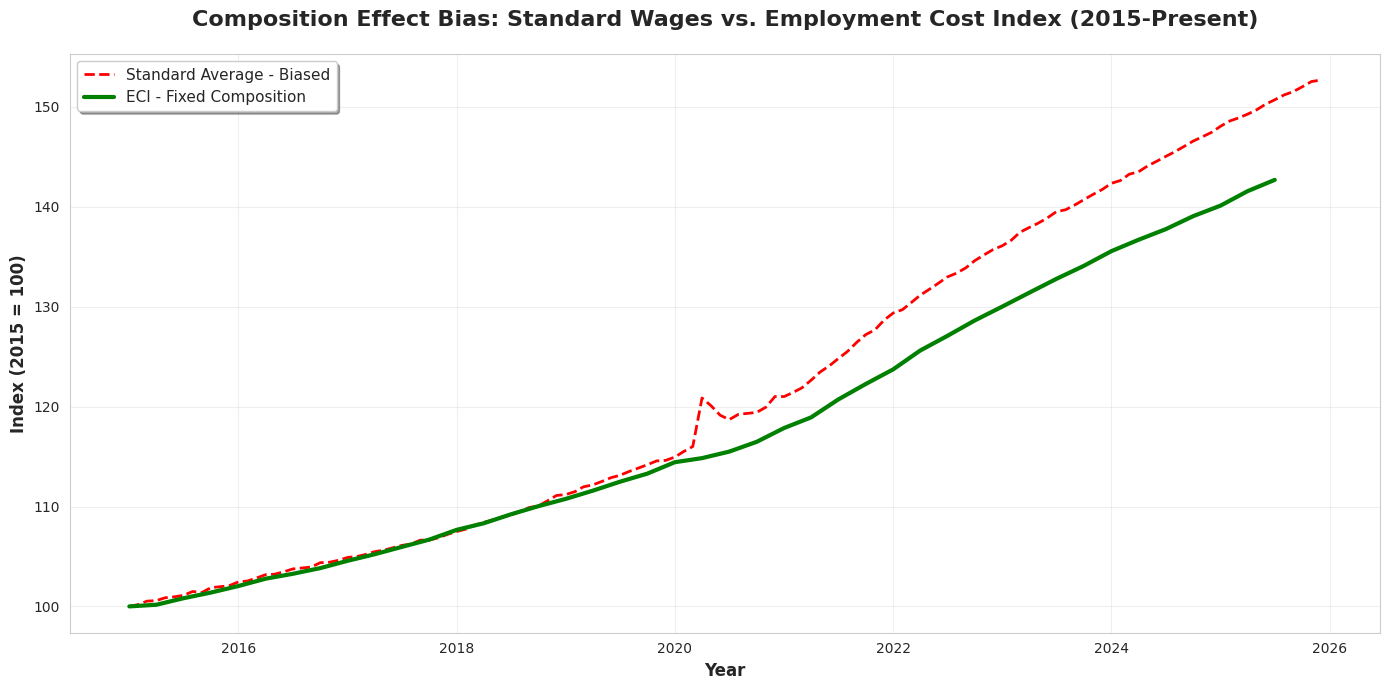


COMPARISON SUMMARY
Standard Wage Growth (2015-Present): 52.7 points
ECI Growth (2015-Present): 42.7 points
Difference (Bias): 10.0 points


In [13]:
# 1. Fetch the Employment Cost Index
print("Fetching ECI data from FRED...")
eci = fred.get_series('ECIWAG')

# 2. Filter both series to 2015 onwards
wages_filtered = wages[wages.index >= '2015-01-01']
eci_filtered = eci[eci.index >= '2015-01-01']

# 3. Rebase both series to 100 (first value = 100)
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# 4. Plot both series
fig, ax = plt.subplots(figsize=(14, 7))

# Standard Average - Biased (Red Dashed)
ax.plot(wages_rebased.index, wages_rebased,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Standard Average - Biased')

# ECI - Fixed Composition (Green Thick)
ax.plot(eci_rebased.index, eci_rebased,
        color='green',
        linewidth=3,
        label='ECI - Fixed Composition')

# Add title and labels
ax.set_title('Composition Effect Bias: Standard Wages vs. Employment Cost Index (2015-Present)',
             fontsize=16,
             fontweight='bold',
             pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Index (2015 = 100)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3)

# 5. Annotate the 2020 divergence
try:
    # Find 2020 data
    mask_2020 = (wages_rebased.index.year == 2020)
    if mask_2020.any():
        # Use middle of 2020 if multiple points
        idx_2020 = wages_rebased.index[mask_2020][len(wages_rebased.index[mask_2020])//2]

        wages_2020 = wages_rebased.loc[idx_2020]
        eci_2020 = eci_rebased.loc[idx_2020]

        # Annotate the artificial spike in standard wages
        ax.annotate('Artificial Spike',
                    xy=(idx_2020, wages_2020),
                    xytext=(idx_2020 - pd.DateOffset(years=1.5), wages_2020 + 3),
                    fontsize=10,
                    color='red',
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5',
                             facecolor='lightyellow',
                             edgecolor='red',
                             linewidth=2),
                    arrowprops=dict(arrowstyle='->',
                                   color='red',
                                   lw=2))

        # Annotate the stable growth in ECI
        ax.annotate('Stable Growth',
                    xy=(idx_2020, eci_2020),
                    xytext=(idx_2020 + pd.DateOffset(years=1), eci_2020 - 3),
                    fontsize=10,
                    color='darkgreen',
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5',
                             facecolor='lightgreen',
                             edgecolor='darkgreen',
                             linewidth=2),
                    arrowprops=dict(arrowstyle='->',
                                   color='darkgreen',
                                   lw=2))
except Exception as e:
    print(f"Note: Could not add 2020 annotations: {e}")

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*50)
print("COMPARISON SUMMARY")
print("="*50)
print(f"Standard Wage Growth (2015-Present): {wages_rebased.iloc[-1] - 100:.1f} points")
print(f"ECI Growth (2015-Present): {eci_rebased.iloc[-1] - 100:.1f} points")
print(f"Difference (Bias): {(wages_rebased.iloc[-1] - eci_rebased.iloc[-1]):.1f} points")


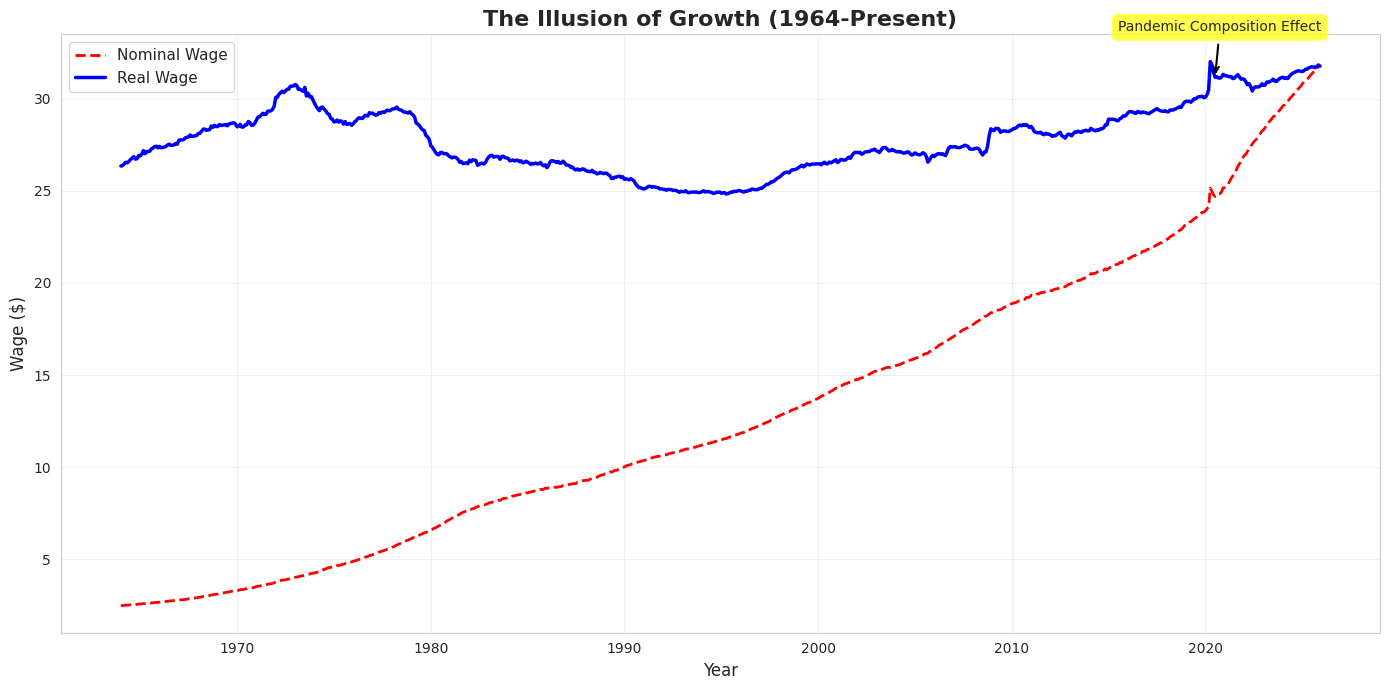

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Create large figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot Nominal Wage (dashed red line)
ax.plot(df.index, df['Nominal_Wage'],
        color='red',
        linestyle='--',
        linewidth=2,
        label='Nominal Wage')

# Plot Real Wage (solid blue line)
ax.plot(df.index, df['Real_Wage'],
        color='blue',
        linewidth=2.5,
        label='Real Wage')

# Add title and labels
ax.set_title('The Illusion of Growth (1964-Present)',
             fontsize=16,
             fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wage ($)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Annotate 2020 spike
try:
    mask_2020 = (df.index.year == 2020)
    if mask_2020.any():
        idx_2020 = df.index[mask_2020][len(df.index[mask_2020])//2]
        real_2020 = df.loc[idx_2020, 'Real_Wage']

        ax.annotate('Pandemic Composition Effect',
                    xy=(idx_2020, real_2020),
                    xytext=(idx_2020 - pd.DateOffset(years=5), real_2020 * 1.08),
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.5',
                             facecolor='yellow',
                             alpha=0.7),
                    arrowprops=dict(arrowstyle='->',
                                   color='black',
                                   lw=1.5))
except Exception as e:
    print(f"Note: Could not add annotation: {e}")

plt.tight_layout()
plt.show()
